In [1]:
import glob #to read the files
import json #to work if .json
import numpy as np #to math
import pandas as pd #to save the data
import math #to convertion calculus
from astropy.time import Time #to time converting
from astropy import units #time correction
from astropy.coordinates import SkyCoord #time correction
from scipy import interpolate #to interpolate the wavelength and flux
from tabulate import tabulate #to export in table format
from scipy.interpolate import interp1d
#import scipy.optimize as opt
from scipy import optimize
from scipy import signal
import os.path
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy import stats
import os.path 
import sncosmo

In [2]:
kernel = 10.0 * RBF(length_scale=10.0, length_scale_bounds=(5, 15)) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))

In [3]:
name = "SN2008hv.json"

In [4]:
with open(name, "r") as read_file:
    data = json.load(read_file)

In [5]:
url = name
if url.endswith('.json'):
    url = url[:-5]

In [6]:
%run ./functions.ipynb

In [7]:
redshift = redshift_value(data[url])

0.012526589416171241


In [8]:
file = open("t0_values.txt")
lines = file.readlines()
file.close()

In [9]:
t0_names = []
t0_values = []

In [10]:
for line in lines:
    if line.startswith('#'): continue
    co=line.rstrip().replace('INDEF','Nan').split()

    t0_names.append(co[0])
    t0_values.append(co[1])

In [11]:
if url in t0_names:
    
    idx = t0_names.index(name[:-5])
    t0 = t0_values[idx]
    print("t0 calculado")
    
else:
    
    t0 = max_time(data[url])
    
    print("t0 fornecido")
    
#t0 = max_time(data[url])

t0 calculado


In [12]:
max_time(data[url])

54814.0

In [13]:
t0

'54816.3'

In [14]:
float(t0)-max_time(data[url])

2.3000000000029104

In [15]:
units = []

In [16]:
if redshift is not None and t0 is not None:
        
    #spectra data
    i=0
    n=0
    while i < len(data[url]["spectra"]):


        if "time" in data[url]["spectra"][i]:

            spectratime = float(data[url]["spectra"][i]["time"]) - float(t0)
            #print(spectratime)

        alert3 = 0
        #if its the first spectra then previous time is the first time
        if i == 0:
            previoustime = spectratime

        else:
            #if the diference between the time and previous time is more than * days so emmit an alert to continue
            if (spectratime - previoustime) < 2000:

                alert3 = 1
                previoustime = spectratime

            #if the diference of time is less than * continue
        if alert3 == 1:

            #verifing if its calibrated and if it have a redshift correction 
            alert1 = 0 #for calibration
            alert2 = 0 #for redshift correction

            if data[url]["spectra"][i]["u_fluxes"] == "erg/s/cm^2/Angstrom":          
                alert1 = 1 #first alert

                if "deredshifted" in data[url]["spectra"][i]:
                    alert2 = 1 #second alert

            #if its calibrated and corrected
            if alert1 == 1 and alert2 == 1:

                #there are 3 collumns: wavelength flux and flux error 
                if len(data[url]["spectra"][i]["data"][0]) == 3:

                    n = n + 1

                #there are 2 collumns: wavelength and flux
                elif len(data[url]["spectra"][i]["data"][0]) == 2:

                    n = n + 1

            #if its calibrated, redshift not adjusted but with a clear redshift
            elif alert1 ==1 and alert2 == 0:   

                #there are 3 collumns: wavelength flux and flux error 
                if len(data[url]["spectra"][i]["data"][0]) == 3:

                    n = n + 1

                #there are 2 collumns: wavelength and flux
                elif len(data[url]["spectra"][i]["data"][0]) == 2:

                    n = n + 1

        i = i + 1

In [17]:
n

13

In [18]:
final_gradex = np.linspace(-20, 50, 71)
final_gradey = np.linspace(2000, 9200, 721)

In [19]:
x = []
y = []
times = []

if n > 4:

    #print(redshift)
    spectra_data = 0
    i=0
    
    while i < len(data[url]["spectra"]):

        if "time" in data[url]["spectra"][i]:

            spectratime = (float(data[url]["spectra"][i]["time"]) - float(t0))/(1+redshift)
            #print(spectratime)
            #verifing if its calibrated and if it have a redshift correction 
            alert1 = 0 #for calibration
            alert2 = 0 #for redshift correction

            if data[url]["spectra"][i]["u_fluxes"] == "erg/s/cm^2/Angstrom":          
                alert1 = 1 #first alert

                if "deredshifted" in data[url]["spectra"][i]:
                    alert2 = 1 #second alert

            #if its calibrated and corrected
            if alert1 == 1 and alert2 == 1:
                #print("ok")
                #there are 3 collumns: wavelength flux and flux error
                if len(data[url]["spectra"][i]["data"][0]) == 3:

                    df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux', 'fluxerror'])

                    #converting to float
                    df['wavelength'] = df['wavelength'].astype(float)
                    df['flux'] = df['flux'].astype(float)
                    
                    
                    #sort the data by wavelength
                    df = df.sort_values(by=['wavelength'])
                    df = df.reset_index(drop=True)

                    #to kill negative fluxes
                    fluxtemp = []
                    for var in range(0,len(df['flux'])):
                        if (df['flux'][var] > 0):
                            fluxtemp.append(df['flux'][var])
                        else:
                            fluxtemp.append(0)            
         
                    #making a list of lists 
                    
                    suavf = suavization(fluxtemp)
                            
                    #if "instrument" in data[url]["spectra"][i]:

                    #if data[url]["spectra"][i]["instrument"] == "fast":

                    x.append(df['wavelength'])
                    y.append(suavf)
                    times.append(spectratime)

                    units.append(data[url]["spectra"][i]["u_fluxes"]) 
                
                
                #there are 2 collumns: wavelength and flux
                if len(data[url]["spectra"][i]["data"][0]) == 2:

                    df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux'])

                    #converting to float
                    df['wavelength'] = df['wavelength'].astype(float)
                    df['flux'] = df['flux'].astype(float)
                    
                    
                    #sort the data by wavelength
                    df = df.sort_values(by=['wavelength'])
                    df = df.reset_index(drop=True)

                    #to kill negative fluxes
                    fluxtemp = []
                    for var in range(0,len(df['flux'])):
                        if (df['flux'][var] > 0):
                            fluxtemp.append(df['flux'][var])
                        else:
                            fluxtemp.append(0)            
      
                    #making a list of lists 
                    suavf = suavization(fluxtemp)
            
                    #if "instrument" in data[url]["spectra"][i]:

                    #if data[url]["spectra"][i]["instrument"] == "fast":

                    x.append(df['wavelength'])
                    y.append(suavf)
                    times.append(spectratime)

                    units.append(data[url]["spectra"][i]["u_fluxes"]) 
                    
            #if its calibrated, redshift not adjusted but with a clear redshift
            
            if alert1 ==1 and alert2 == 0:  
                
                #there are 3 collumns: wavelength flux and flux error 
                if len(data[url]["spectra"][i]["data"][0]) == 3:

                    df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux', 'fluxerror'])

                    #converting to float
                    df['wavelength'] = df['wavelength'].astype(float)
                    df['flux'] = df['flux'].astype(float)
                    
                    
                    #sort the data by wavelength
                    df = df.sort_values(by=['wavelength'])
                    df = df.reset_index(drop=True)

                    #to kill negative fluxes
                    fluxtemp = []
                    for var in range(0,len(df['flux'])):
                        if (df['flux'][var] > 0):
                            fluxtemp.append(df['flux'][var])
                        else:
                            fluxtemp.append(0)


                    #redshift correction
                    fluxtemp = [x * (((1+redshift))**3) for x in fluxtemp] #for the flux           
                    df['wavelength'] = [x * (1/(1+redshift)) for x in df['wavelength']] #for the wavelength
                    #spectratime = spectratime/(1+redshift) #for time
         
                    #making a list of lists 
                    suavf = suavization(fluxtemp)
 
                    #if "instrument" in data[url]["spectra"][i]:

                    #if data[url]["spectra"][i]["instrument"] == "fast":

                    x.append(df['wavelength'])
                    y.append(suavf)
                    times.append(spectratime)

                    units.append(data[url]["spectra"][i]["u_fluxes"]) 
                    
                #there are 2 collumns: wavelength flux and flux error 
                if len(data[url]["spectra"][i]["data"][0]) == 2:

                    df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux'])

                    #converting to float
                    df['wavelength'] = df['wavelength'].astype(float)
                    df['flux'] = df['flux'].astype(float)
                    
                    
                    #sort the data by wavelength
                    df = df.sort_values(by=['wavelength'])
                    df = df.reset_index(drop=True)

                    #to kill negative fluxes
                    fluxtemp = []
                    for var in range(0,len(df['flux'])):
                        if (df['flux'][var] > 0):
                            fluxtemp.append(df['flux'][var])
                        else:
                            fluxtemp.append(0)

                    #redshift correction
                    fluxtemp = [x * (((1+redshift))**3) for x in fluxtemp] #for the flux           
                    df['wavelength'] = [x * (1/(1+redshift)) for x in df['wavelength']] #for the wavelength
                    #spectratime = spectratime/(1+redshift) #for time
       
                    #making a list of lists 
                    suavf = suavization(fluxtemp)
            
                            
                    #if "instrument" in data[url]["spectra"][i]:

                    #if data[url]["spectra"][i]["instrument"] == "fast":

                    x.append(df['wavelength'])
                    y.append(suavf)
                    times.append(spectratime)

                    units.append(data[url]["spectra"][i]["u_fluxes"])  
              
        i = i + 1


In [20]:
mag = []
time = []
system = []

for i in range(0,len(data[url]["photometry"])):

    if "band" in data[url]["photometry"][i]:

        if data[url]["photometry"][i]["band"] == "V":
            
            if "system" in data[url]["photometry"][i]:
                
                system.append(data[url]["photometry"][i]["system"])

                mag.append(float(data[url]["photometry"][i]["magnitude"]))
                time.append(float(data[url]["photometry"][i]["time"]))
            
            else:
                
                system.append("w")

                mag.append(float(data[url]["photometry"][i]["magnitude"]))
                time.append(float(data[url]["photometry"][i]["time"]))


In [21]:
csp = sncosmo.get_magsystem('csp')
ab = sncosmo.get_magsystem('ab')
vega = sncosmo.get_magsystem('vega')

In [22]:
maxvalues = []

In [23]:
if len(time) > 3:

    #maxvalues.append(min(mag))
    
    ntime = []
    nmag = []
    for i in range(0,len(mag)):

        if np.abs(time[i]- min(time)) < 100:
                
            if system[i] == "CSP":
                
                
                nmag.append(csp.band_mag_to_flux(mag[i], 'cspv9844')*(1+redshift)**3)
                ntime.append([time[i]])
                
            if system[i] == "AB":
                #print("ab")
                
                nmag.append(ab.band_mag_to_flux(mag[i], 'cspv9844')*(1+redshift)**3)
                ntime.append([time[i]])
                
            if system[i] == "Vega":
                
                #print("vega")
                nmag.append(vega.band_mag_to_flux(mag[i], 'cspv9844')*(1+redshift)**3)
                ntime.append([time[i]])   
                
            if system[i] == "w":
                
                #print("w")
                nmag.append(vega.band_mag_to_flux(mag[i], 'cspv9844')*(1+redshift)**3)
                ntime.append([time[i]])                     
                              
            #print(np.abs(time[i][0] - min(time[i])))                         
        
    if len(nmag) > 3:   
        
        gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(ntime, nmag)

        X_ = np.linspace(min(ntime)[0], max(ntime)[0], 1000)

        y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)


## Curvas de luz não integradas

In [24]:
len(x)

14

In [25]:
wavenumber = 4000

In [26]:
time = []
flux = []

In [27]:
for i in range(0,len(times)):
    
    if min(x[i]) < wavenumber < max(x[i]):
    
        interpolation = interp1d(x[i], y[i])
        
        time.append([times[i]])
        flux.append(interpolation(wavenumber))
        

<IPython.core.display.Javascript object>


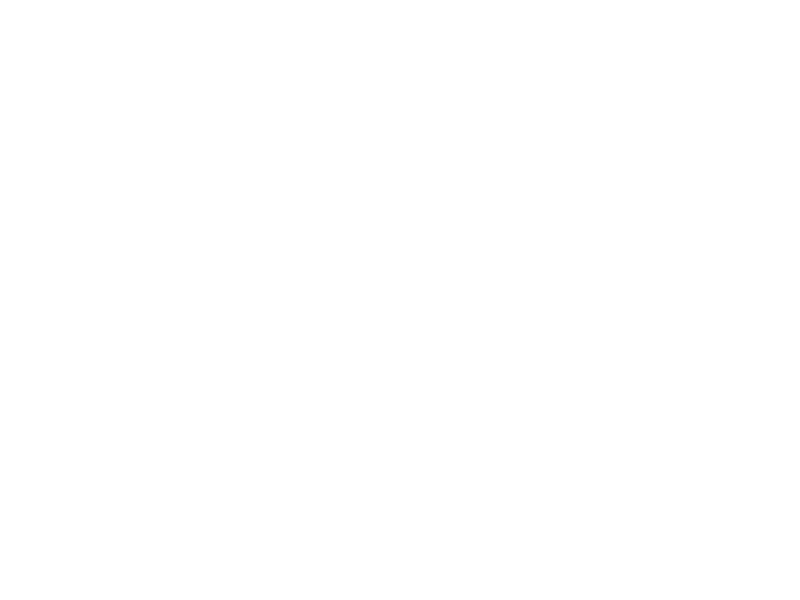

In [28]:
%matplotlib notebook

plt.figure(figsize=(8,6))
plt.plot(time, flux,'k.')
plt.xlabel('flux (erg/s/cm^2/Angstrom)')
plt.ylabel('time (days)')
plt.xlim(-20,50)
plt.show()

In [29]:
time

[[-5.915894024530366],
 [-0.9382469654966208],
 [2.004885620998206],
 [2.0345144725389184],
 [3.911008403524974],
 [7.841769374741362],
 [10.854035948166914],
 [11.83178804904636],
 [23.68332866579132],
 [56.19605509105993],
 [71.06973856507975]]

In [30]:
max(y_mean)

0.7055804824643396

<IPython.core.display.Javascript object>


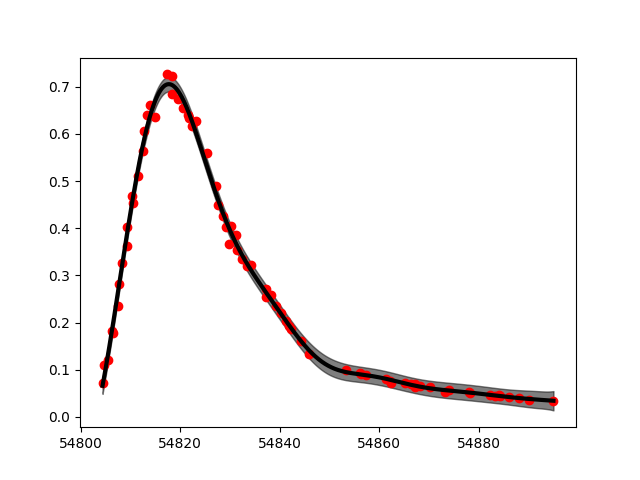

In [31]:
%matplotlib notebook
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.plot(ntime, nmag,'ro')
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')
plt.show()

In [32]:
'''
save_path = '/home/joao/Documentos/templates/data'

for i in range(0,len(x)):
    
    table = []
    for k in range(0,len(x[i])):
        table.append((x[i][k], y[i][k]))


    name_of_file = str(url)

    completeName = os.path.join(save_path, name_of_file+str(i)+".dat")      

    header = '#' + str(times[i])
    
    f = open(completeName, 'w')               
    f.write(header + "\n")
    f.write(tabulate(table, tablefmt="plain"))
    f.close()
    

    
    print(i)
'''

'\nsave_path = \'/home/joao/Documentos/templates/data\'\n\nfor i in range(0,len(x)):\n    \n    table = []\n    for k in range(0,len(x[i])):\n        table.append((x[i][k], y[i][k]))\n\n\n    name_of_file = str(url)\n\n    completeName = os.path.join(save_path, name_of_file+str(i)+".dat")      \n\n    header = \'#\' + str(times[i])\n    \n    f = open(completeName, \'w\')               \n    f.write(header + "\n")\n    f.write(tabulate(table, tablefmt="plain"))\n    f.close()\n    \n\n    \n    print(i)\n'

In [33]:
units

['erg/s/cm^2/Angstrom',
 'erg/s/cm^2/Angstrom',
 'erg/s/cm^2/Angstrom',
 'erg/s/cm^2/Angstrom',
 'erg/s/cm^2/Angstrom',
 'erg/s/cm^2/Angstrom',
 'erg/s/cm^2/Angstrom',
 'erg/s/cm^2/Angstrom',
 'erg/s/cm^2/Angstrom',
 'erg/s/cm^2/Angstrom',
 'erg/s/cm^2/Angstrom',
 'erg/s/cm^2/Angstrom',
 'erg/s/cm^2/Angstrom',
 'erg/s/cm^2/Angstrom']